<a href="https://colab.research.google.com/github/nickplas/Intro_to_ML_24-25/blob/main/challenges/challenge-one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge 1: The banknote-authentication data set problem

We will perform a nearly realistic analysis of the data set bank note authentication that can be downloaded from https://archive.ics.uci.edu/dataset/267/banknote+authentication

## Data set description

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.
These features are:
1. variance of Wavelet Transformed image (continuous) 
2. skewness of Wavelet Transformed image (continuous) 
3. curtosis of Wavelet Transformed image (continuous) 
4. entropy of image (continuous) 
5. class (integer)

## Task description
We have a binary classification problem. The assignment can be divided in several parts:
    
    1. Load the data and pretreatment.
    2. Data exploring by Unsupervised Learning techniques.
    3. Construction of several models of Supervised Learning.

### 1. Data pretreatment

Load the data and look at it: It is needed some kind of scaling? Why? Are the data points sorted in the original data set? Can it generate problems? How can this be solved?

Step 1: Load Data and preliminary EDA

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [7]:
df = pd.read_csv("data/data_banknote_authentication.txt", names=['variance', 'skewness', 'kurtosis', 'entropy', 'class'], header=None)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   kurtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [9]:
df.head()

,variance,skewness,kurtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [10]:
df.tail()

,variance,skewness,kurtosis,entropy,class
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1
1371,-2.54190,-0.65804,2.6842,1.19520,1


In [11]:
df.describe()

,variance,skewness,kurtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


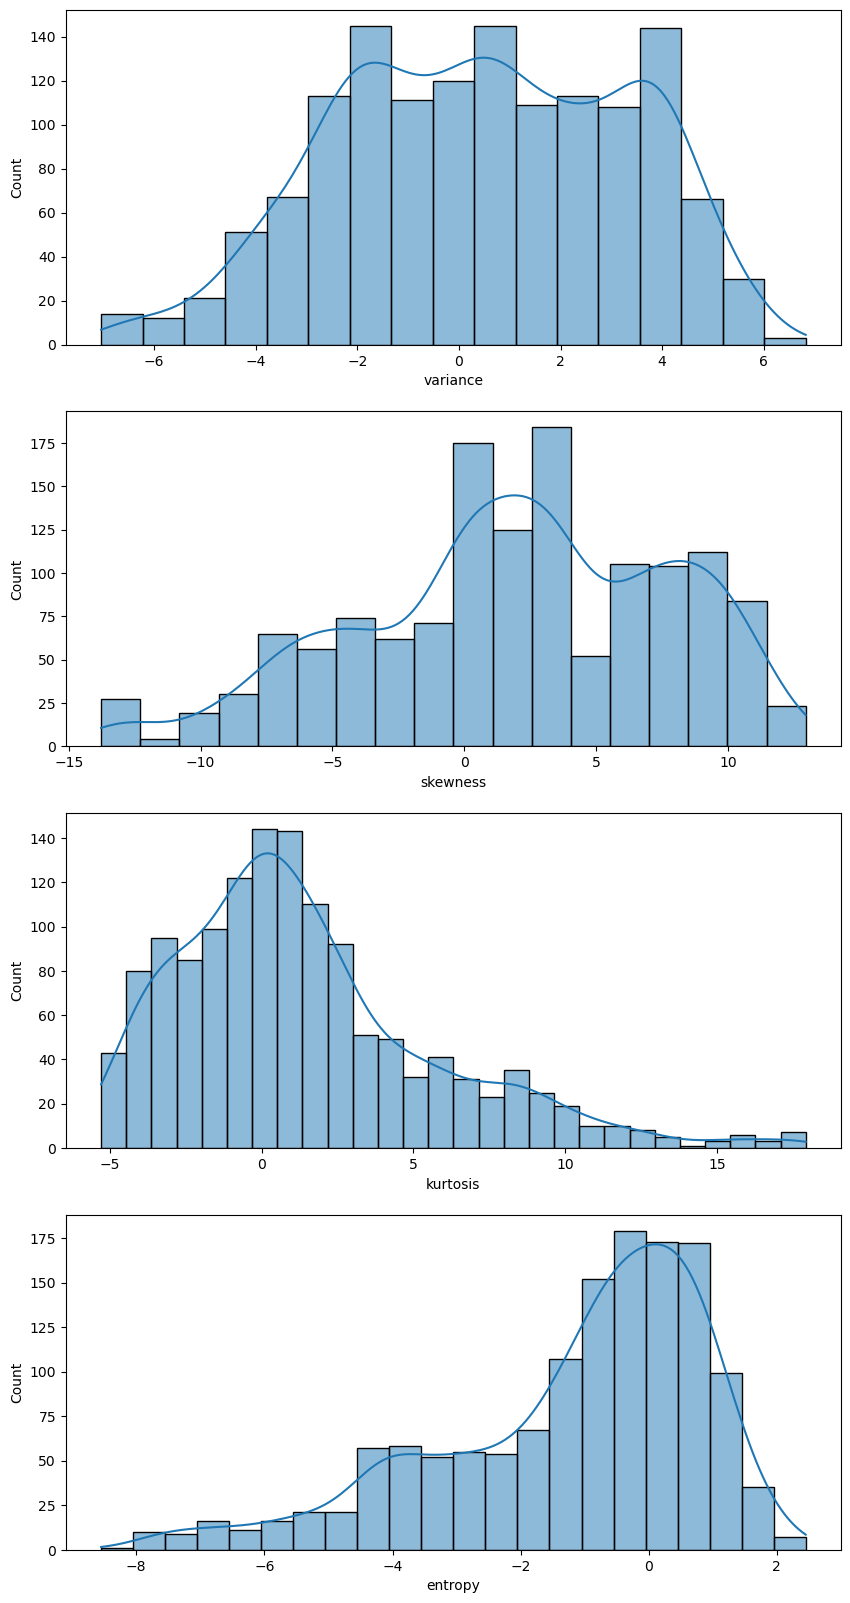

In [12]:
columns = ['variance', 'skewness', 'kurtosis', 'entropy']

fig, axes = plt.subplots(4,1, figsize=(10, 20))

for i,col in enumerate(columns):
    sns.histplot(df, x=col, ax=axes[i], kde=True)

plt.show()

As we can see, the numerical columns may need scaling as they are distributed in different ways (two of them are in fact, skewed). As none of the explanatory variables seem to present outliers, it might be reasonable to apply standard scaling.

We are applying scaling to the dataset as it is crucial for distance-based clustering algorithms (for instance KMeans)


In [13]:
from sklearn.preprocessing import StandardScaler

my_scaler = StandardScaler()

for col in columns:
    my_scaler.fit(df[[col]])
    df[col] = my_scaler.transform(df[[col]])


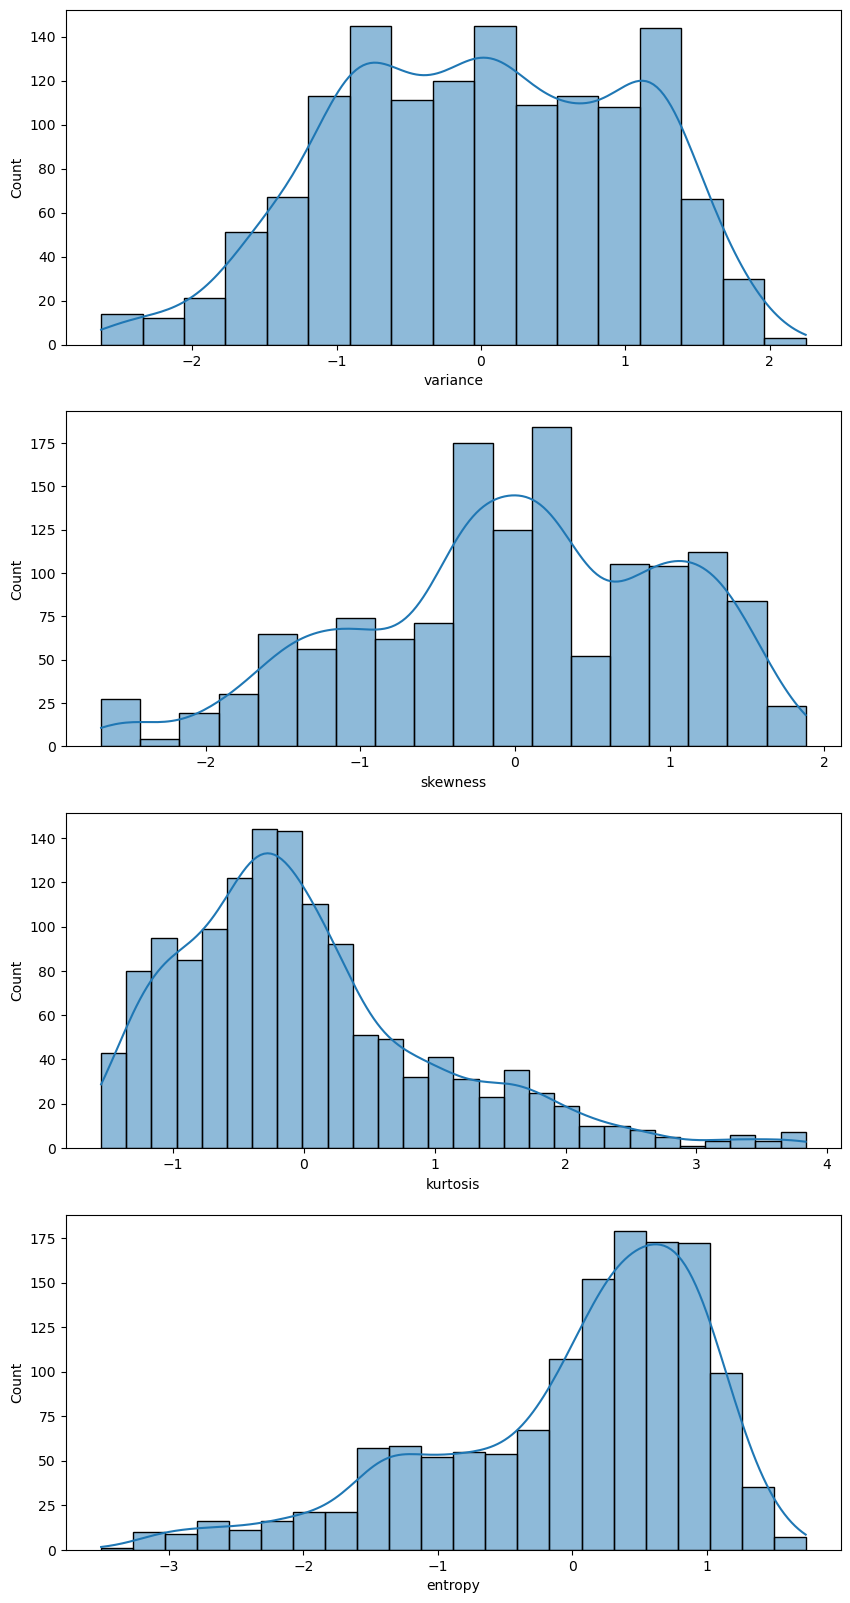

In [14]:
fig, axes = plt.subplots(4,1, figsize=(10, 20))

for i,col in enumerate(columns):
    sns.histplot(df, x=col, ax=axes[i], kde=True)

plt.show()

Moreover, the results given by the `.head()` and `.tail()` commands might suggest us that the datapoints are sorted by the `class` variable. To confirm this we will look at the indexes of datapoints with class 0 and 1.

In [15]:
df_0 = df[df['class'] == 0]
df_1 = df[df['class'] == 1]

idx0 = df_0.index.tolist()
idx1 = df_1.index.tolist()

if list(range(0, max(idx0)+1)) == idx0:
    print(f"From 0 to {max(idx0)} there are datapoints with ONLY class 0")

if list(range(min(idx1), max(idx1)+1)) == idx1:
    print(f"From {min(idx1)} to {max(idx1)} there are datapoints with ONLY class 1")

From 0 to 761 there are datapoints with ONLY class 0
From 762 to 1371 there are datapoints with ONLY class 1


This confirms our suspicion that the datapoints are sorted by the `class` variable. This might represent a potential problem in our model validation and training phase, as the simple hold-out method (without shuffling) will generate unbalanced train-test splits (for example, if we create a 70% training set and 30% validation set, the training test will be dominated by class 0 and the test set will only have class 1). To fix this we can either:
- Shuffle the original dataset
- Use more sophisticated model validation techniques (shuffled hold-out method, shuffled and stratified K-folds, and so on...)
We will take the simplest approach, i.e. the first one.

In [16]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
df

,variance,skewness,kurtosis,entropy,class
0,0.399533,0.754085,-0.366820,-0.580048,0
1,-0.250466,1.067981,-1.051751,-0.636089,0
2,-0.134340,0.874353,-0.801151,-0.932816,0
3,-0.770530,1.708489,0.393870,-1.764622,0
4,0.702026,1.271496,-1.078188,-0.125054,0
...,...,...,...,...,...
1367,0.256979,0.339301,-1.381475,-1.273918,1
1368,-0.959112,-1.564598,1.523067,1.005956,1
1369,-2.628731,1.256326,-0.285876,-1.594071,1
1370,-1.370377,0.130861,-0.286872,0.080589,1


**Extra: 3D Visualization of the dataset**

In [18]:
import plotly.express as px

px.scatter_3d(df, x='variance', y='skewness', z='kurtosis', color='entropy')

As there are no missing variables in the dataset, we can consider the *data preprocessing* phase to be finished.

### 2. Unsupervised Learning

Use PCA and plot the two first components colouring according with the class. Are the classes linearly separable in this projection? What happens when I applied k-means with two classes in this space? And if I use all the coordinates? Try also t-SNE for projection and DBSCAN for the clustering and comment on the results.

In [19]:
# Import models from SKLEARN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN

In [20]:
# Define X, the train variables and y the target variable
X = df.drop('class', axis=1)
y = df['class']

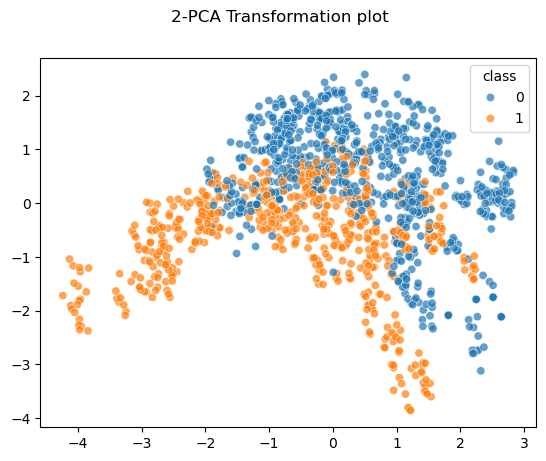

In [21]:
# Run PCA on the dataset and plot the transformed dataset
X_2PCA = PCA(n_components=2).fit_transform(X)

sns.scatterplot(x=X_2PCA[:, 0], y=X_2PCA[:,1], hue=y, alpha=0.7) # Transparency to see if there are "overlaps" in classes
plt.suptitle("2-PCA Transformation plot")
plt.show()

Clearly with 2-PCA projection the classes are not *separable* at all. Let's try to use KMeans:

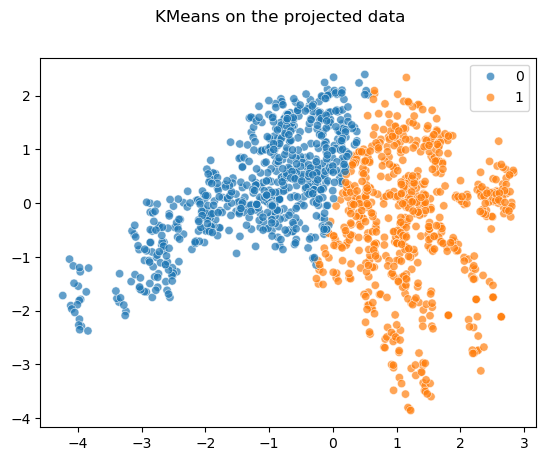

In [22]:
kmeans_clusterer = KMeans(2)
Kmeans_labels = kmeans_clusterer.fit_predict(X_2PCA)

sns.scatterplot(x=X_2PCA[:, 0], y=X_2PCA[:,1], hue=Kmeans_labels, alpha=0.7) # Transparency to see if there are "overlaps" in classes
plt.suptitle("KMeans on the projected data")
plt.show()

KMeans failed to provide a faithful separation of two clusters. We can try to improve this result by using all coordinates, i.e. using a 3-PCA transformation

In [23]:
X_3PCA = PCA(n_components=3).fit_transform(X)


f = px.scatter_3d(x=X_3PCA[:, 0], y=X_3PCA[:,1], z=X_3PCA[:, 2], color=y,
                  title = "3D PCA Transformation") # Transparency to see if there are "overlaps" in classes
f.show()

Analogously to the two-dimensional case, we still do not have a completely separable dataset. By applying KMeans again we have

In [24]:
kmeans_clusterer = KMeans(2)
Kmeans_labels = kmeans_clusterer.fit_predict(X_3PCA)

f = px.scatter_3d(x=X_3PCA[:, 0], y=X_3PCA[:,1], z=X_3PCA[:, 2], color=Kmeans_labels,
                  title = "KMeans on 3-PCA Transformation")
f.show()

Now we use T-SNE and DBSCAN to see if we can improve our results:

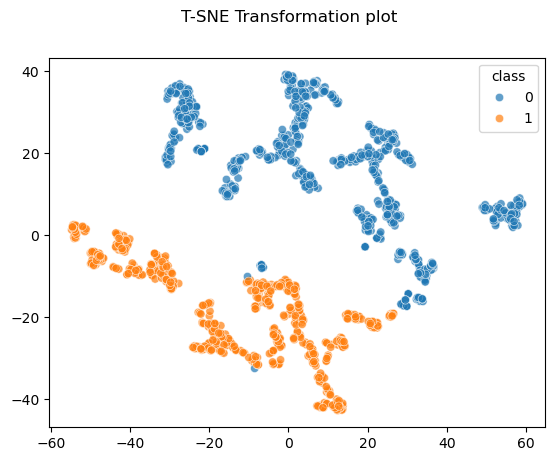

In [25]:
T_SNE = TSNE(perplexity=30)
X_TSNE = T_SNE.fit_transform(X)

sns.scatterplot(x=X_TSNE[:, 0], y=X_TSNE[:,1], hue=y, alpha=0.7) # Transparency to see if there are "overlaps" in classes
plt.suptitle("T-SNE Transformation plot")
plt.show()

We have a "way better" result, where classes seem to be separable. However, in the PCA-transformed dataset there are a few "singular" points which are far away from their clusters and close to the other one. Now let us run DBScan to detect both noise points (the aforementioned "singular" points) and estimate a number of classes.

There are 122 noise points


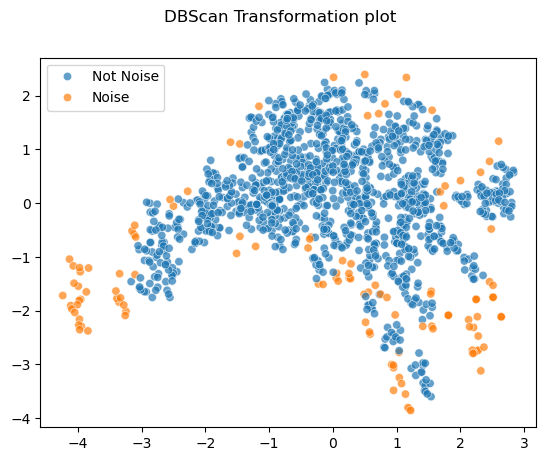

In [26]:
dbscanner = DBSCAN(eps = .20, min_samples = 7)
DBSCAN_labels = dbscanner.fit_predict(X_2PCA)

# Process DBScan labels
mask = ["Noise" if x == -1 else "Not Noise" for x in DBSCAN_labels]
n_noise_ = list(DBSCAN_labels).count(-1)

print("There are",n_noise_,"noise points")

sns.scatterplot(x=X_2PCA[:, 0], y=X_2PCA[:,1], hue=mask, alpha=0.7) # Transparency to see if there are "overlaps" in classes
plt.suptitle("DBScan Transformation plot")
plt.show()

There are 0 noise points


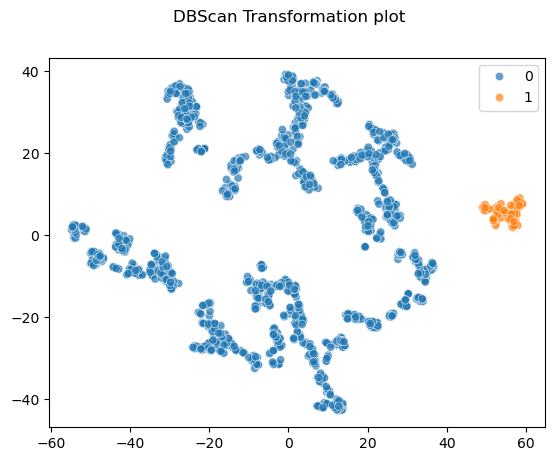

In [27]:
dbscanner = DBSCAN(eps=9)
DBSCAN_labels = dbscanner.fit_predict(X_TSNE)

# Process DBScan labels
n_noise_ = list(DBSCAN_labels).count(-1)

print("There are",n_noise_,"noise points")

sns.scatterplot(x=X_TSNE[:, 0], y=X_TSNE[:,1], hue=DBSCAN_labels, alpha=0.7) # Transparency to see if there are "overlaps" in classes
plt.suptitle("DBScan Transformation plot")
plt.show()

In [28]:
from sklearn.cluster import AgglomerativeClustering

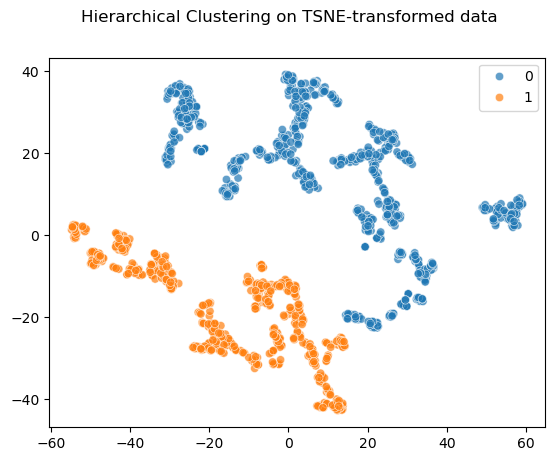

In [29]:
agglomerer = AgglomerativeClustering(2, linkage='ward')
agglomerer_labels = agglomerer.fit_predict(X_TSNE)

# Process DBScan labels
sns.scatterplot(x=X_TSNE[:, 0], y=X_TSNE[:,1], hue=agglomerer_labels, alpha=0.7) # Transparency to see if there are "overlaps" in classes
plt.suptitle("Hierarchical Clustering on TSNE-transformed data")
plt.show()

### 3. Supervised Learning

Generate a subset of the data of 372 elements that would be saved as test set. With the rest of the data generate the following models: Logistic Regression, Decision tree (use the ID3 algorithm), Naive Bayesian and k-NN. 

Investigate the effect of regularization (when possible) and use cross validation for setting the hyper-parameters when needed. 

Compare the performances in terms of accuracy, precision, recall and F1-score on the test set. Comment these results at the light of those obtained from the Unsupervised Learning analysis. Could you propose a way to improve these results?     


In [34]:
# Import models from SKLEARN
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [35]:
# Define function to run model, evaluate it with stratified 5-folds and return the average of F1-scores
def run_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=372, random_state=42) # Random state ensures that the split is ALWAYS the same
    
    model.fit(X_train, y_train)
    y_test_hat = model.predict(X_test)

    f1 = (f1_score(y_test, y_test_hat))

    print(f"The model {model} has performed on the test dataset with the average {f1}")
    return f1

In [36]:
MODELS = [
    DecisionTreeClassifier(criterion='entropy'),
    LogisticRegression(None),
    LogisticRegression('l2'),
    LogisticRegression('elasticnet', solver='saga', l1_ratio=0.25, max_iter=1000),
    LogisticRegression('elasticnet', solver='saga', l1_ratio=0.50, max_iter=1000),
    LogisticRegression('elasticnet', solver='saga', l1_ratio=0.75, max_iter=1000),
    LogisticRegression('l1', solver='saga', max_iter=1000),
    GaussianNB(),
    KNeighborsClassifier()
]

f1_scores = {}

for model in MODELS:
    f1_score_i = run_model(model, X,y)

    f1_scores[model] = [f1_score_i]

The model DecisionTreeClassifier(criterion='entropy') has performed on the test dataset with the average 0.9873417721518988
The model LogisticRegression(penalty=None) has performed on the test dataset with the average 0.9968253968253968
The model LogisticRegression() has performed on the test dataset with the average 0.9781931464174455
The model LogisticRegression(l1_ratio=0.25, max_iter=1000, penalty='elasticnet',
                   solver='saga') has performed on the test dataset with the average 0.9781931464174455
The model LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   solver='saga') has performed on the test dataset with the average 0.9781931464174455
The model LogisticRegression(l1_ratio=0.75, max_iter=1000, penalty='elasticnet',
                   solver='saga') has performed on the test dataset with the average 0.9843260188087775
The model LogisticRegression(max_iter=1000, penalty='l1', solver='saga') has performed on the test dataset w

Plot models evaluations (with variance)

In [37]:
df_results = pd.DataFrame(f1_scores)
df_results_processed = df_results.T.reset_index().rename(columns={'index': 'model', 0: 'performance'})
df_results_processed

,model,performance
0,DecisionTreeClassifier(criterion='entropy'),0.987342
1,LogisticRegression(penalty=None),0.996825
2,LogisticRegression(),0.978193
3,"LogisticRegression(l1_ratio=0.25, max_iter=100...",0.978193
4,"LogisticRegression(l1_ratio=0.5, max_iter=1000...",0.978193
5,"LogisticRegression(l1_ratio=0.75, max_iter=100...",0.984326
6,"LogisticRegression(max_iter=1000, penalty='l1'...",0.987421
7,GaussianNB(),0.798742
8,KNeighborsClassifier(),1.000000


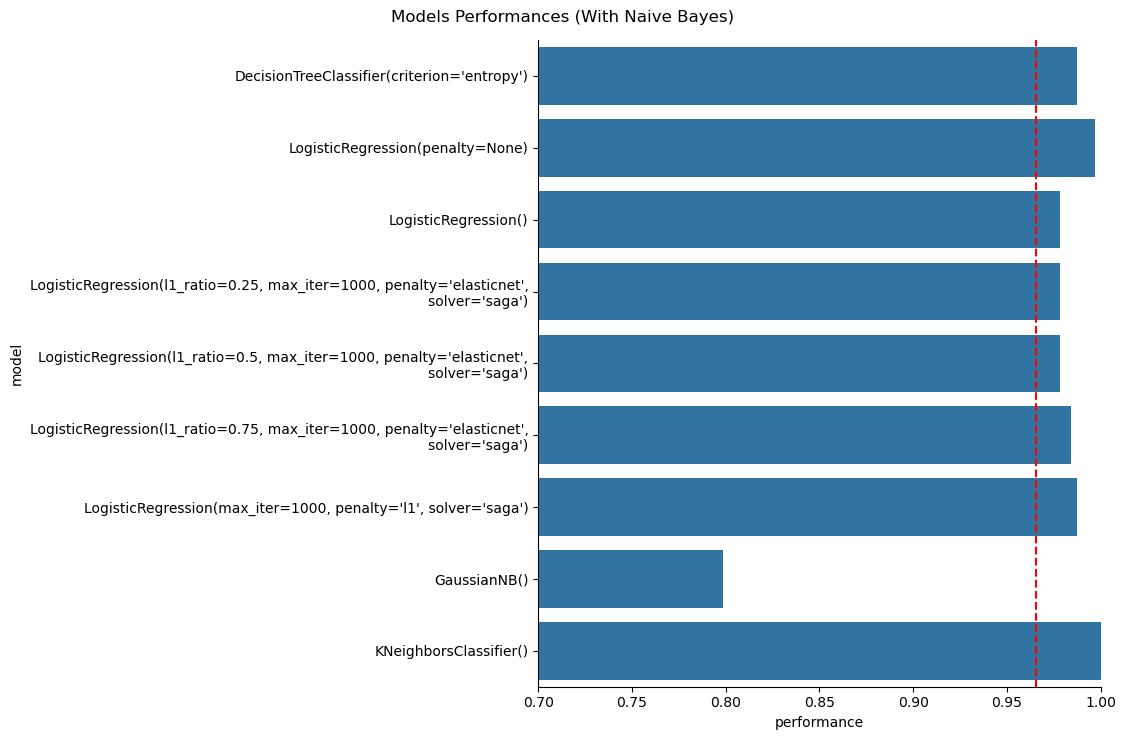

In [38]:
sns.catplot(df_results_processed, y='model', x='performance', kind='bar', height=7.5, aspect=1.5/1)
plt.suptitle("Models Performances (With Naive Bayes)")
plt.xlim(0.7, 1)
plt.axvline(np.mean(list(f1_scores.values())), color='r', linestyle='--')
plt.tight_layout()
plt.show()

KNN works, which is weird because KMeans didn't work (???)
try to use transformed dataset (TSNE) to do supervised learning

In [39]:

f1_scores_tsne = {}

for model in MODELS:
    f1_score_i = run_model(model, X_TSNE,y)
    f1_scores_tsne[model] = [f1_score_i]

The model DecisionTreeClassifier(criterion='entropy') has performed on the test dataset with the average 1.0
The model LogisticRegression(penalty=None) has performed on the test dataset with the average 1.0
The model LogisticRegression() has performed on the test dataset with the average 1.0
The model LogisticRegression(l1_ratio=0.25, max_iter=1000, penalty='elasticnet',
                   solver='saga') has performed on the test dataset with the average 0.9937106918238994
The model LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   solver='saga') has performed on the test dataset with the average 0.9937106918238994


c:\Users\ACER\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\ACER\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\ACER\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



The model LogisticRegression(l1_ratio=0.75, max_iter=1000, penalty='elasticnet',
                   solver='saga') has performed on the test dataset with the average 0.9937106918238994
The model LogisticRegression(max_iter=1000, penalty='l1', solver='saga') has performed on the test dataset with the average 0.9937106918238994
The model GaussianNB() has performed on the test dataset with the average 0.9753086419753086
The model KNeighborsClassifier() has performed on the test dataset with the average 1.0


c:\Users\ACER\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [40]:
df_results_tsne = pd.DataFrame(f1_scores_tsne)
df_results_processed_tsne = df_results_tsne.T.reset_index().rename(columns={'index': 'model', 0: 'performance'})
df_results_processed_tsne

,model,performance
0,DecisionTreeClassifier(criterion='entropy'),1.000000
1,LogisticRegression(penalty=None),1.000000
2,LogisticRegression(),1.000000
3,"LogisticRegression(l1_ratio=0.25, max_iter=100...",0.993711
4,"LogisticRegression(l1_ratio=0.5, max_iter=1000...",0.993711
5,"LogisticRegression(l1_ratio=0.75, max_iter=100...",0.993711
6,"LogisticRegression(max_iter=1000, penalty='l1'...",0.993711
7,GaussianNB(),0.975309
8,KNeighborsClassifier(),1.000000


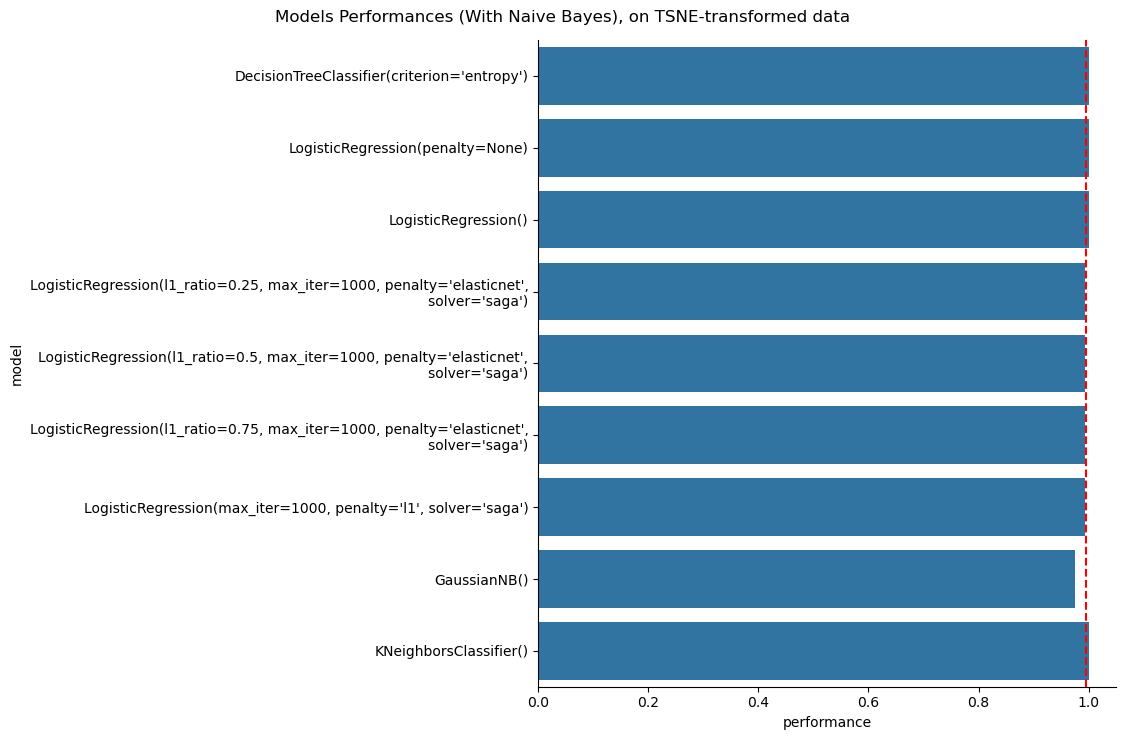

In [41]:
sns.catplot(df_results_processed_tsne, y='model', x='performance', height=7.5, aspect=1.5/1, kind='bar')
plt.suptitle("Models Performances (With Naive Bayes), on TSNE-transformed data")
plt.axvline(np.mean(list(f1_scores_tsne.values())), color='r', linestyle='--')
plt.tight_layout()
plt.show()

In [42]:
df_results_processed['type'] = 'Original'
df_results_processed_tsne['type'] = 'TSNE'

df_results_combined = pd.concat([df_results_processed, df_results_processed_tsne])
df_results_combined

,model,performance,type
0,DecisionTreeClassifier(criterion='entropy'),0.987342,Original
1,LogisticRegression(penalty=None),0.996825,Original
2,LogisticRegression(),0.978193,Original
3,"LogisticRegression(l1_ratio=0.25, max_iter=100...",0.978193,Original
4,"LogisticRegression(l1_ratio=0.5, max_iter=1000...",0.978193,Original
5,"LogisticRegression(l1_ratio=0.75, max_iter=100...",0.984326,Original
6,"LogisticRegression(max_iter=1000, penalty='l1'...",0.987421,Original
7,GaussianNB(),0.798742,Original
8,KNeighborsClassifier(),1.000000,Original
0,DecisionTreeClassifier(criterion='entropy'),1.000000,TSNE


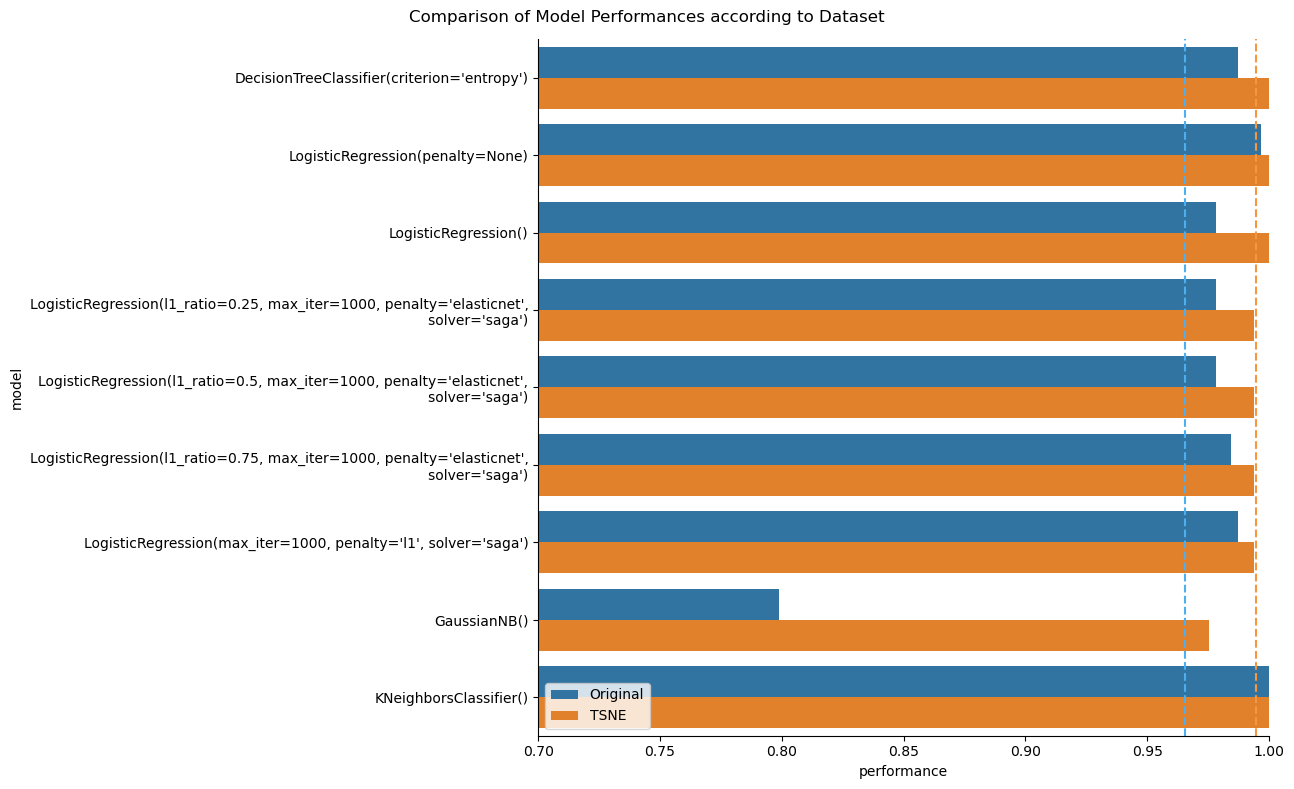

In [43]:
g = sns.catplot(df_results_combined, x='performance', y='model', hue='type', kind='bar',  height=8, aspect=1.5/1, legend_out=True)
g._legend.remove()
plt.xlim(0.7, 1)
plt.suptitle("Comparison of Model Performances according to Dataset")
plt.axvline(np.mean(list(f1_scores.values())), color='#4daef0', linestyle='--')
plt.axvline(np.mean(list(f1_scores_tsne.values())), color='#f79640', linestyle='--')

plt.legend(loc = 'lower left')

plt.tight_layout()

plt.show()

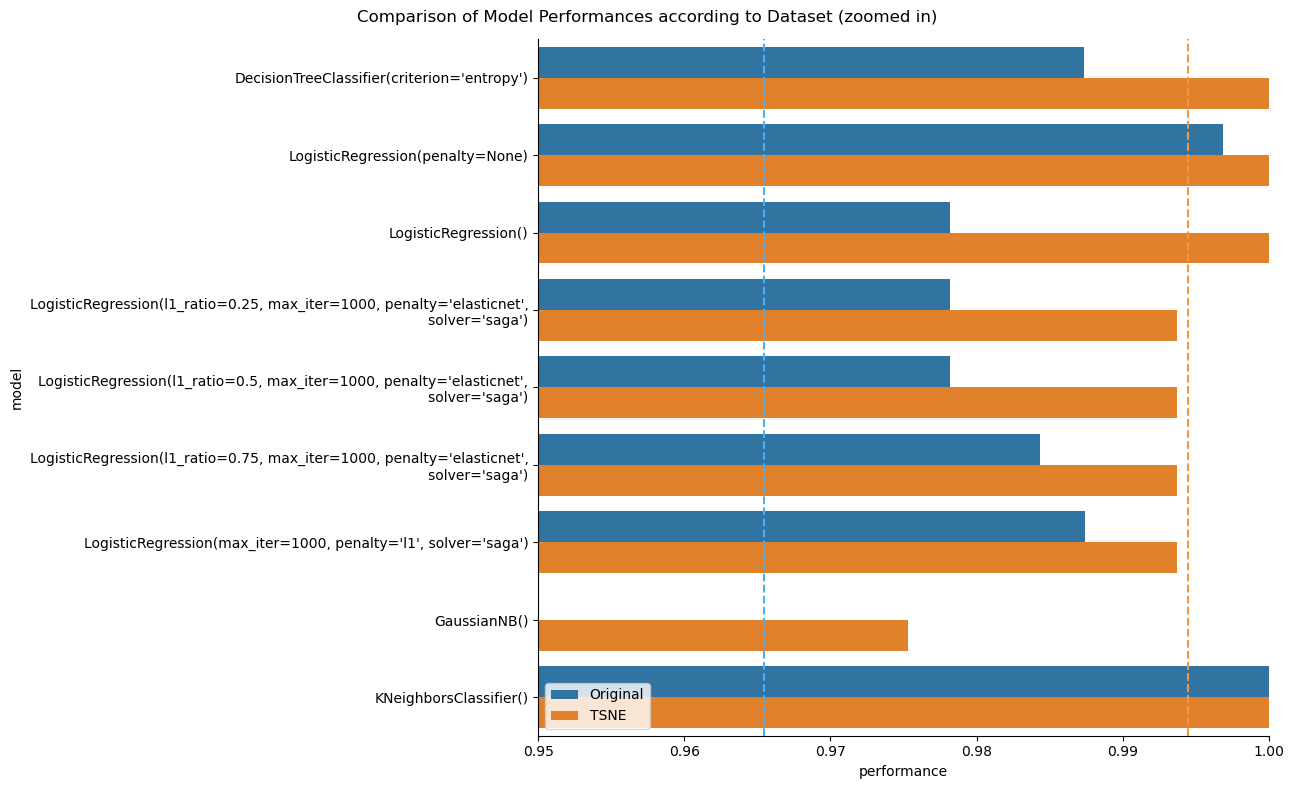

In [44]:
g = sns.catplot(df_results_combined, x='performance', y='model', hue='type', kind='bar',  height=8, aspect=1.5/1, legend_out=True)
g._legend.remove()
plt.xlim(0.95, 1)
plt.suptitle("Comparison of Model Performances according to Dataset (zoomed in)")
plt.axvline(np.mean(list(f1_scores.values())), color='#4daef0', linestyle='--')
plt.axvline(np.mean(list(f1_scores_tsne.values())), color='#f79640', linestyle='--')

plt.legend(loc = 'lower left')

plt.tight_layout()

plt.show()

Final remarks: 
- NB got a super boost (from around .8 to .965)
- Others got 'small' boosts (in orders of 10^{-2}) in any case

Is this information leak???

Probably, because I did it BEFORE running the models. If I transformed the variables AFTER splitting the data then it would be ok

Actually not because the TSNE algorithm did not look at y in any way so uhhh ok